In [1]:
!pip install transformers

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import utils.config
import random

cuda


1. Vocabulary

In [3]:
from utils.tokeniser import get_bag_of_characters, Tokenizer
from utils.config import path_chess_moves

# Fetching characters and max length from all possible chess moves
temp_vocab, MAX_LENGTH = get_bag_of_characters(path_chess_moves, return_max=True)
# Creating a voabular dictionary
vocab = {char: idx for idx, char in enumerate(temp_vocab, 1)}
# Tokeniser object
tokenizer = Tokenizer(vocab, MAX_LENGTH)
# Defining number of classes
NUM_CLASSES = len(vocab)

2. Dataset and dataloader 

In [4]:
# Identifying synthetic data 
from utils.datasets import get_image_ids, split_array
from utils.config import path_images

img_ids = get_image_ids(path_images)
random.shuffle(img_ids)
train_ids, val_ids = split_array(img_ids,ratio=0.8, debug=False)

/home/bradicic/miniconda/envs/deep_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# TRAIN/VAL data
from utils.datasets import ChessDataset, TestDataset
from utils.config import IMG_DIM, BATCH_SIZE, path_test_images, path_csv 

train_dataset = ChessDataset(path_images, IMG_DIM, train_ids, tokenizer)
validation_dataset = ChessDataset(path_images, IMG_DIM, val_ids, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# TEST dataset
test_dataset = TestDataset(path_csv, path_test_images, tokenizer, IMG_DIM)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train dataset samples (synthetic): 


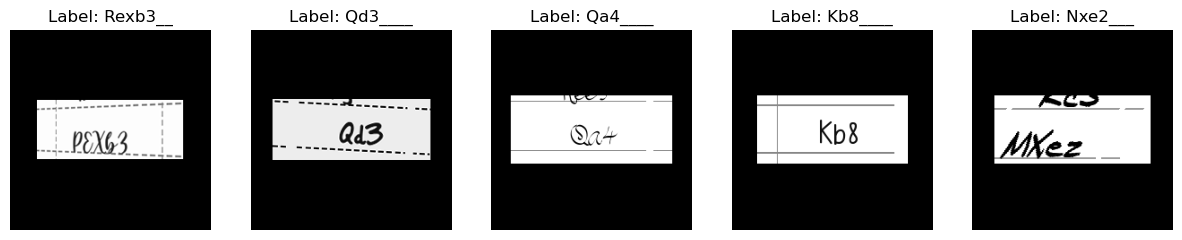

Validation dataset samples (synthetic): 


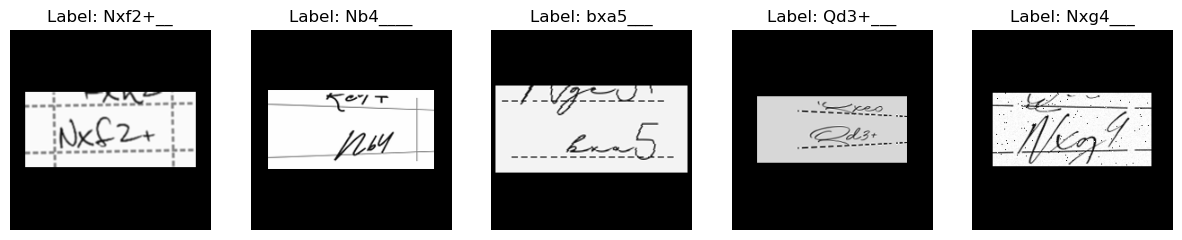

Test dataset samples: 


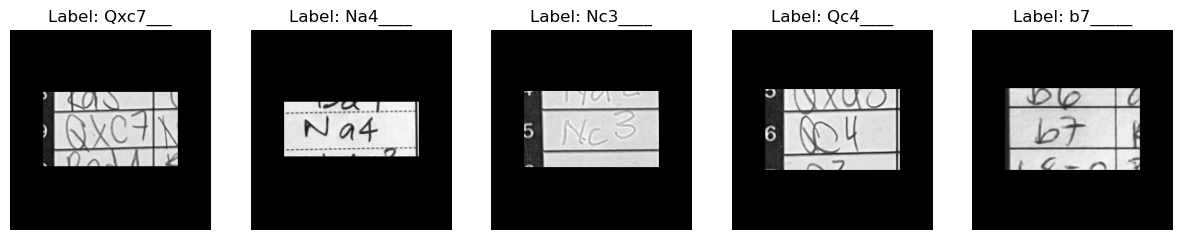

In [7]:
from utils.plotting import plot_samples

print("Train dataset samples (synthetic): ")
fig, axes = plt.subplots(1, 5, figsize=(15,6))
plot_samples(axes, train_dataset, tokenizer)
plt.show()

print("Validation dataset samples (synthetic): ")
fig, axes = plt.subplots(1, 5, figsize=(15,6))
plot_samples(axes, validation_dataset, tokenizer)
plt.show()

print("Test dataset samples: ")
fig, axes = plt.subplots(1, 5, figsize=(15,6))
plot_samples(axes, test_dataset, tokenizer)
plt.show()

3. Model

In [8]:
from utils.model import ViTSequenceClassifier, get_criterion
from utils.config import LR, LOSS_NAME, device, loss_hist

model = ViTSequenceClassifier(num_classes=NUM_CLASSES, max_length=MAX_LENGTH).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = get_criterion(LOSS_NAME)

In [9]:
#Evaluate model
path = "saved/model_832.pth"
model.load_state_dict(torch.load(path, weights_only=False, map_location=torch.device('cpu') ))

model.eval()
sum = 0
pred = np.array([])
true = np.array([])

for x,y in test_dataloader:
    x,y = x.to(device), y.to(device)
    y = y.cpu().numpy()
    true = np.append(true, y.flatten())

    out = model(x)
    out = torch.argmax(out, dim=2)
    out = out.cpu().numpy()
    out = [x[x != 0] for x in out]
    out = np.array([np.pad(arr, (0, 7 - len(arr)), constant_values=0) for arr in out])
    pred = np.append(pred, out.flatten())

    sum += np.sum(np.all(out == y, axis=1))

print(f"Sum of correctly predicted notations: {sum}")
print(f"Accuracy on Test data: {round(sum/(len(test_dataset))*100,4)}%")

/home/bradicic/miniconda/envs/deep_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1711403388920/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Sum of correctly predicted notations: 832
Accuracy on Test data: 62.3688%


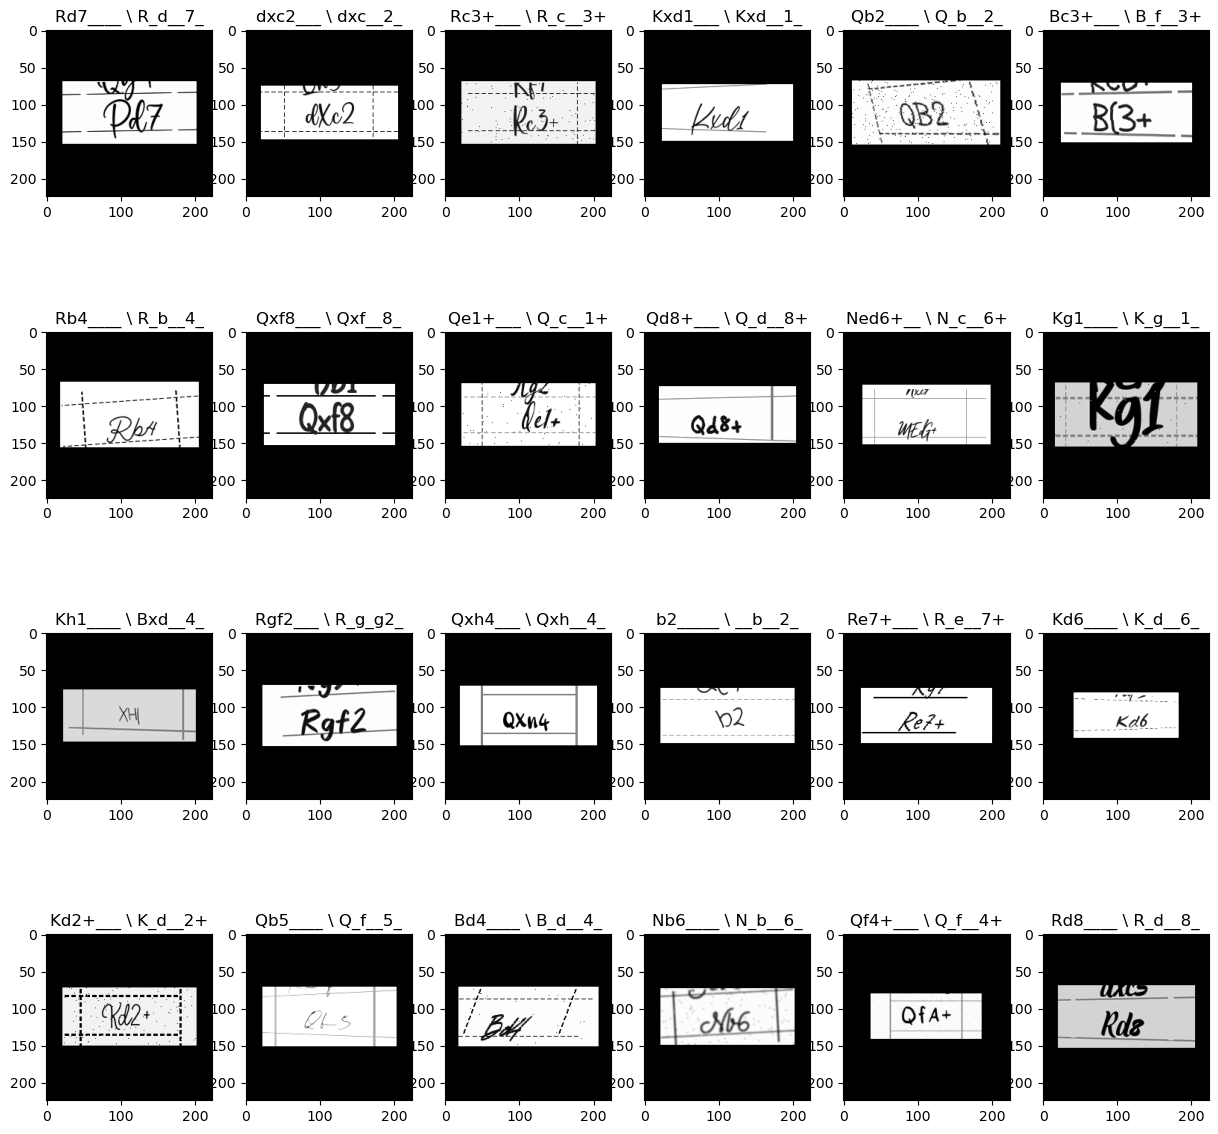

In [10]:
# Samples of the predicted notations using ViT
figs = (4,6)
x,y = next(iter(val_dataloader))
out = model(x.to(device))
out = torch.argmax(out,dim=2)

fig, ax = plt.subplots(figs[0], figs[1], figsize=(15,15))
ax = ax.flatten()
for i in range(0,figs[0]*figs[1]):
    ax[i].imshow(x[i][0,:,:], cmap="gray")
    pred = tokenizer.decode(out[i].cpu().numpy())
    true = tokenizer.decode(y[i].cpu().numpy())
    ax[i].set_title(f"{true} \ {pred}")


In [9]:
# Train the model
from utils.model import train_model, save_logs
from utils.config import NUM_EPOCHES, BATCH_SIZE, loss_hist, LOSS_NAME

train_model(model, train_dataloader, val_dataloader, test_dataloader, optimizer, criterion, device, loss_hist, epochs=NUM_EPOCHES, batch_size=BATCH_SIZE, loss_name=LOSS_NAME)

Epoch 1/10:   0%|          | 0/1250 [00:00<?, ?batch/s]/home/bradicic/miniconda/envs/deep_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1711403388920/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/10: 100%|██████████| 1250/1250 [17:06<00:00,  1.22batch/s]


559
0.9467041446208113
Epoch 1/10, Train Loss: 5.07195616, Val Loss: 2.37290382
Dictionary saved to logs/output_2024-12-19_0804.csv


Epoch 2/10: 100%|██████████| 1250/1250 [14:24<00:00,  1.45batch/s]


758
0.6321373456790124
Epoch 2/10, Train Loss: 1.68756135, Val Loss: 1.51801658
Dictionary saved to logs/output_2024-12-19_0804.csv


Epoch 3/10: 100%|██████████| 1250/1250 [14:23<00:00,  1.45batch/s]


676
0.7670855379188714
Epoch 3/10, Train Loss: 0.90779955, Val Loss: 1.27888393
Dictionary saved to logs/output_2024-12-19_0804.csv


Epoch 4/10: 100%|██████████| 1250/1250 [14:25<00:00,  1.44batch/s]


647
0.7932649911816577
Epoch 4/10, Train Loss: 0.53603659, Val Loss: 1.33337533
Dictionary saved to logs/output_2024-12-19_0804.csv


Epoch 5/10: 100%|██████████| 1250/1250 [14:27<00:00,  1.44batch/s]


577
0.8754684744268078
Epoch 5/10, Train Loss: 0.33646111, Val Loss: 1.32412338
Dictionary saved to logs/output_2024-12-19_0804.csv


Epoch 6/10: 100%|██████████| 1250/1250 [14:28<00:00,  1.44batch/s]


787
0.656360229276896
Epoch 6/10, Train Loss: 0.23890758, Val Loss: 1.41114402
Dictionary saved to logs/output_2024-12-19_0804.csv


Epoch 7/10: 100%|██████████| 1250/1250 [14:25<00:00,  1.44batch/s]


511
0.9747023809523809
Epoch 7/10, Train Loss: 0.19963399, Val Loss: 1.48006380
Dictionary saved to logs/output_2024-12-19_0804.csv


Epoch 8/10: 100%|██████████| 1250/1250 [14:26<00:00,  1.44batch/s]


761
0.6340939153439153
Epoch 8/10, Train Loss: 0.18309580, Val Loss: 1.48471081
Dictionary saved to logs/output_2024-12-19_0804.csv


Epoch 9/10: 100%|██████████| 1250/1250 [14:27<00:00,  1.44batch/s]


755
0.6320546737213404
Epoch 9/10, Train Loss: 0.13899943, Val Loss: 1.49675429
Dictionary saved to logs/output_2024-12-19_0804.csv


Epoch 10/10: 100%|██████████| 1250/1250 [14:27<00:00,  1.44batch/s]


811
0.6043320105820106
Epoch 10/10, Train Loss: 0.11917197, Val Loss: 1.51609015
Dictionary saved to logs/output_2024-12-19_0804.csv
